In [ ]:
!pip install Wand

In [ ]:
!sudo apt-get install libmagickwand-dev

In [ ]:
import os
from PIL import Image
import os.path
import time
import torch
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch.utils.data as data
import numpy as np

import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings

In [ ]:
# import data path
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/'


Mounted at /content/drive


We have conducted experiments on the robustness of motion blur, color space, CAE and EDSR augmentations. This document shows the first half part of each models in the experiments -- Data Augmentation.

For each model, we have a sample part and an actual implementation part.

# EDSR

## Sample

Since EDSR method is a complicated neural network data augmentation method, we are directly showing the images in the sample.

Reference: https://github.com/hendrycks/imagenet-r

Before EDSR:


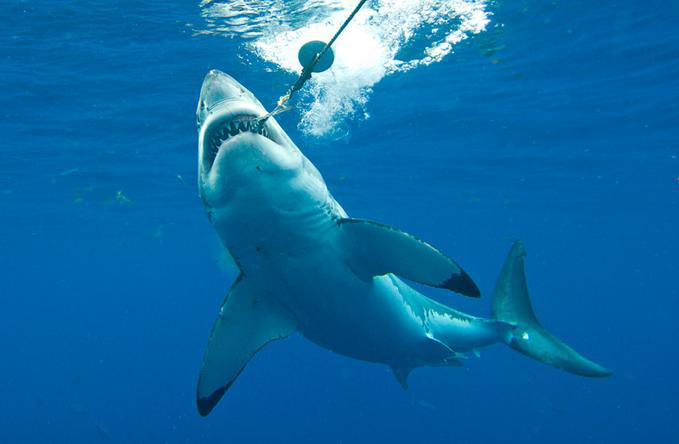

In [ ]:
print("Before EDSR:")
# Read a sample image
img3 = Image.open(data_path+'pre_EDSR_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

Before EDSR:


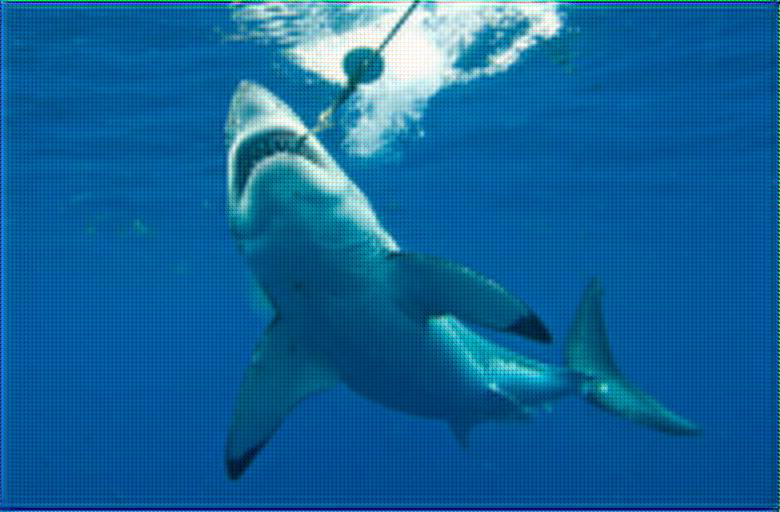

In [ ]:
print("After EDSR:")
# Read a sample image
img3 = Image.open(data_path+'after_EDSR_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

## Actual Data Augmentation

In [ ]:
import torch
#/home/jtang/robustness/imagenet-r/DeepAugment/EDSR_Model
from EDSR_Model import common
import torch.nn as nn
from torchvision import transforms as trn
from torchvision import datasets
import torchvision.transforms.functional as trnF
import numpy as np
from torch.nn.functional import gelu
from torch.nn.functional import conv2d
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import sys
import os
from PIL import Image

import torch.nn.functional as F

from tqdm import tqdm

import os
import shutil
import tempfile
import random

import torchvision

import argparse

In [ ]:
total_workers = 1
worker_number = 0

all_classes = ["n01440764", "n01443537", "n01484850", "n01491361", "n01494475", "n01496331", "n01498041", "n01514668", "n01514859", "n01518878", "n01530575", "n01531178", "n01532829", "n01534433", "n01537544", "n01558993", "n01560419", "n01580077", "n01582220", "n01592084", "n01601694", "n01608432", "n01614925", "n01616318", "n01622779", "n01629819", "n01630670", "n01631663", "n01632458", "n01632777", "n01641577", "n01644373", "n01644900", "n01664065", "n01665541", "n01667114", "n01667778", "n01669191", "n01675722", "n01677366", "n01682714", "n01685808", "n01687978", "n01688243", "n01689811", "n01692333", "n01693334", "n01694178", "n01695060", "n01697457", "n01698640", "n01704323", "n01728572", "n01728920", "n01729322", "n01729977", "n01734418", "n01735189", "n01737021", "n01739381", "n01740131", "n01742172", "n01744401", "n01748264", "n01749939", "n01751748", "n01753488", "n01755581", "n01756291", "n01768244", "n01770081", "n01770393", "n01773157", "n01773549", "n01773797", "n01774384", "n01774750", "n01775062", "n01776313", "n01784675", "n01795545", "n01796340", "n01797886", "n01798484", "n01806143", "n01806567", "n01807496", "n01817953", "n01818515", "n01819313", "n01820546", "n01824575", "n01828970", "n01829413", "n01833805", "n01843065", "n01843383", "n01847000", "n01855032", "n01855672", "n01860187", "n01871265", "n01872401", "n01873310", "n01877812", "n01882714", "n01883070", "n01910747", "n01914609", "n01917289", "n01924916", "n01930112", "n01943899", "n01944390", "n01945685", "n01950731", "n01955084", "n01968897", "n01978287", "n01978455", "n01980166", "n01981276", "n01983481", "n01984695", "n01985128", "n01986214", "n01990800", "n02002556", "n02002724", "n02006656", "n02007558", "n02009229", "n02009912", "n02011460", "n02012849", "n02013706", "n02017213", "n02018207", "n02018795", "n02025239", "n02027492", "n02028035", "n02033041", "n02037110", "n02051845", "n02056570", "n02058221", "n02066245", "n02071294", "n02074367", "n02077923", "n02085620", "n02085782", "n02085936", "n02086079", "n02086240", "n02086646", "n02086910", "n02087046", "n02087394", "n02088094", "n02088238", "n02088364", "n02088466", "n02088632", "n02089078", "n02089867", "n02089973", "n02090379", "n02090622", "n02090721", "n02091032", "n02091134", "n02091244", "n02091467", "n02091635", "n02091831", "n02092002", "n02092339", "n02093256", "n02093428", "n02093647", "n02093754", "n02093859", "n02093991", "n02094114", "n02094258", "n02094433", "n02095314", "n02095570", "n02095889", "n02096051", "n02096177", "n02096294", "n02096437", "n02096585", "n02097047", "n02097130", "n02097209", "n02097298", "n02097474", "n02097658", "n02098105", "n02098286", "n02098413", "n02099267", "n02099429", "n02099601", "n02099712", "n02099849", "n02100236", "n02100583", "n02100735", "n02100877", "n02101006", "n02101388", "n02101556", "n02102040", "n02102177", "n02102318", "n02102480", "n02102973", "n02104029", "n02104365", "n02105056", "n02105162", "n02105251", "n02105412", "n02105505", "n02105641", "n02105855", "n02106030", "n02106166", "n02106382", "n02106550", "n02106662", "n02107142", "n02107312", "n02107574", "n02107683", "n02107908", "n02108000", "n02108089", "n02108422", "n02108551", "n02108915", "n02109047", "n02109525", "n02109961", "n02110063", "n02110185", "n02110341", "n02110627", "n02110806", "n02110958", "n02111129", "n02111277", "n02111500", "n02111889", "n02112018", "n02112137", "n02112350", "n02112706", "n02113023", "n02113186", "n02113624", "n02113712", "n02113799", "n02113978", "n02114367", "n02114548", "n02114712", "n02114855", "n02115641", "n02115913", "n02116738", "n02117135", "n02119022", "n02119789", "n02120079", "n02120505", "n02123045", "n02123159", "n02123394", "n02123597", "n02124075", "n02125311", "n02127052", "n02128385", "n02128757", "n02128925", "n02129165", "n02129604", "n02130308", "n02132136", "n02133161", "n02134084", "n02134418", "n02137549", "n02138441", "n02165105", "n02165456", "n02167151", "n02168699", "n02169497", "n02172182", "n02174001", "n02177972", "n02190166", "n02206856", "n02219486", "n02226429", "n02229544", "n02231487", "n02233338", "n02236044", "n02256656", "n02259212", "n02264363", "n02268443", "n02268853", "n02276258", "n02277742", "n02279972", "n02280649", "n02281406", "n02281787", "n02317335", "n02319095", "n02321529", "n02325366", "n02326432", "n02328150", "n02342885", "n02346627", "n02356798", "n02361337", "n02363005", "n02364673", "n02389026", "n02391049", "n02395406", "n02396427", "n02397096", "n02398521", "n02403003", "n02408429", "n02410509", "n02412080", "n02415577", "n02417914", "n02422106", "n02422699", "n02423022", "n02437312", "n02437616", "n02441942", "n02442845", "n02443114", "n02443484", "n02444819", "n02445715", "n02447366", "n02454379", "n02457408", "n02480495", "n02480855", "n02481823", "n02483362", "n02483708", "n02484975", "n02486261", "n02486410", "n02487347", "n02488291", "n02488702", "n02489166", "n02490219", "n02492035", "n02492660", "n02493509", "n02493793", "n02494079", "n02497673", "n02500267", "n02504013", "n02504458", "n02509815", "n02510455", "n02514041", "n02526121", "n02536864", "n02606052", "n02607072", "n02640242", "n02641379", "n02643566", "n02655020", "n02666196", "n02667093", "n02669723", "n02672831", "n02676566", "n02687172", "n02690373", "n02692877", "n02699494", "n02701002", "n02704792", "n02708093", "n02727426", "n02730930", "n02747177", "n02749479", "n02769748", "n02776631", "n02777292", "n02782093", "n02783161", "n02786058", "n02787622", "n02788148", "n02790996", "n02791124", "n02791270", "n02793495", "n02794156", "n02795169", "n02797295", "n02799071", "n02802426", "n02804414", "n02804610", "n02807133", "n02808304", "n02808440", "n02814533", "n02814860", "n02815834", "n02817516", "n02823428", "n02823750", "n02825657", "n02834397", "n02835271", "n02837789", "n02840245", "n02841315", "n02843684", "n02859443", "n02860847", "n02865351", "n02869837", "n02870880", "n02871525", "n02877765", "n02879718", "n02883205", "n02892201", "n02892767", "n02894605", "n02895154", "n02906734", "n02909870", "n02910353", "n02916936", "n02917067", "n02927161", "n02930766", "n02939185", "n02948072", "n02950826", "n02951358", "n02951585", "n02963159", "n02965783", "n02966193", "n02966687", "n02971356", "n02974003", "n02977058", "n02978881", "n02979186", "n02980441", "n02981792", "n02988304", "n02992211", "n02992529", "n02999410", "n03000134", "n03000247", "n03000684", "n03014705", "n03016953", "n03017168", "n03018349", "n03026506", "n03028079", "n03032252", "n03041632", "n03042490", "n03045698", "n03047690", "n03062245", "n03063599", "n03063689", "n03065424", "n03075370", "n03085013", "n03089624", "n03095699", "n03100240", "n03109150", "n03110669", "n03124043", "n03124170", "n03125729", "n03126707", "n03127747", "n03127925", "n03131574", "n03133878", "n03134739", "n03141823", "n03146219", "n03160309", "n03179701", "n03180011", "n03187595", "n03188531", "n03196217", "n03197337", "n03201208", "n03207743", "n03207941", "n03208938", "n03216828", "n03218198", "n03220513", "n03223299", "n03240683", "n03249569", "n03250847", "n03255030", "n03259280", "n03271574", "n03272010", "n03272562", "n03290653", "n03291819", "n03297495", "n03314780", "n03325584", "n03337140", "n03344393", "n03345487", "n03347037", "n03355925", "n03372029", "n03376595", "n03379051", "n03384352", "n03388043", "n03388183", "n03388549", "n03393912", "n03394916", "n03400231", "n03404251", "n03417042", "n03424325", "n03425413", "n03443371", "n03444034", "n03445777", "n03445924", "n03447447", "n03447721", "n03450230", "n03452741", "n03457902", "n03459775", "n03461385", "n03467068", "n03476684", "n03476991", "n03478589", "n03481172", "n03482405", "n03483316", "n03485407", "n03485794", "n03492542", "n03494278", "n03495258", "n03496892", "n03498962", "n03527444", "n03529860", "n03530642", "n03532672", "n03534580", "n03535780", "n03538406", "n03544143", "n03584254", "n03584829", "n03590841", "n03594734", "n03594945", "n03595614", "n03598930", "n03599486", "n03602883", "n03617480", "n03623198", "n03627232", "n03630383", "n03633091", "n03637318", "n03642806", "n03649909", "n03657121", "n03658185", "n03661043", "n03662601", "n03666591", "n03670208", "n03673027", "n03676483", "n03680355", "n03690938", "n03691459", "n03692522", "n03697007", "n03706229", "n03709823", "n03710193", "n03710637", "n03710721", "n03717622", "n03720891", "n03721384", "n03724870", "n03729826", "n03733131", "n03733281", "n03733805", "n03742115", "n03743016", "n03759954", "n03761084", "n03763968", "n03764736", "n03769881", "n03770439", "n03770679", "n03773504", "n03775071", "n03775546", "n03776460", "n03777568", "n03777754", "n03781244", "n03782006", "n03785016", "n03786901", "n03787032", "n03788195", "n03788365", "n03791053", "n03792782", "n03792972", "n03793489", "n03794056", "n03796401", "n03803284", "n03804744", "n03814639", "n03814906", "n03825788", "n03832673", "n03837869", "n03838899", "n03840681", "n03841143", "n03843555", "n03854065", "n03857828", "n03866082", "n03868242", "n03868863", "n03871628", "n03873416", "n03874293", "n03874599", "n03876231", "n03877472", "n03877845", "n03884397", "n03887697", "n03888257", "n03888605", "n03891251", "n03891332", "n03895866", "n03899768", "n03902125", "n03903868", "n03908618", "n03908714", "n03916031", "n03920288", "n03924679", "n03929660", "n03929855", "n03930313", "n03930630", "n03933933", "n03935335", "n03937543", "n03938244", "n03942813", "n03944341", "n03947888", "n03950228", "n03954731", "n03956157", "n03958227", "n03961711", "n03967562", "n03970156", "n03976467", "n03976657", "n03977966", "n03980874", "n03982430", "n03983396", "n03991062", "n03992509", "n03995372", "n03998194", "n04004767", "n04005630", "n04008634", "n04009552", "n04019541", "n04023962", "n04026417", "n04033901", "n04033995", "n04037443", "n04039381", "n04040759", "n04041544", "n04044716", "n04049303", "n04065272", "n04067472", "n04069434", "n04070727", "n04074963", "n04081281", "n04086273", "n04090263", "n04099969", "n04111531", "n04116512", "n04118538", "n04118776", "n04120489", "n04125021", "n04127249", "n04131690", "n04133789", "n04136333", "n04141076", "n04141327", "n04141975", "n04146614", "n04147183", "n04149813", "n04152593", "n04153751", "n04154565", "n04162706", "n04179913", "n04192698", "n04200800", "n04201297", "n04204238", "n04204347", "n04208210", "n04209133", "n04209239", "n04228054", "n04229816", "n04235860", "n04238763", "n04239074", "n04243546", "n04251144", "n04252077", "n04252225", "n04254120", "n04254680", "n04254777", "n04258138", "n04259630", "n04263257", "n04264628", "n04265275", "n04266014", "n04270147", "n04273569", "n04275548", "n04277352", "n04285008", "n04286575", "n04296562", "n04310018", "n04311004", "n04311174", "n04317175", "n04325704", "n04326547", "n04328186", "n04330267", "n04332243", "n04335435", "n04336792", "n04344873", "n04346328", "n04347754", "n04350905", "n04355338", "n04355933", "n04356056", "n04357314", "n04366367", "n04367480", "n04370456", "n04371430", "n04371774", "n04372370", "n04376876", "n04380533", "n04389033", "n04392985", "n04398044", "n04399382", "n04404412", "n04409515", "n04417672", "n04418357", "n04423845", "n04428191", "n04429376", "n04435653", "n04442312", "n04443257", "n04447861", "n04456115", "n04458633", "n04461696", "n04462240", "n04465501", "n04467665", "n04476259", "n04479046", "n04482393", "n04483307", "n04485082", "n04486054", "n04487081", "n04487394", "n04493381", "n04501370", "n04505470", "n04507155", "n04509417", "n04515003", "n04517823", "n04522168", "n04523525", "n04525038", "n04525305", "n04532106", "n04532670", "n04536866", "n04540053", "n04542943", "n04548280", "n04548362", "n04550184", "n04552348", "n04553703", "n04554684", "n04557648", "n04560804", "n04562935", "n04579145", "n04579432", "n04584207", "n04589890", "n04590129", "n04591157", "n04591713", "n04592741", "n04596742", "n04597913", "n04599235", "n04604644", "n04606251", "n04612504", "n04613696", "n06359193", "n06596364", "n06785654", "n06794110", "n06874185", "n07248320", "n07565083", "n07579787", "n07583066", "n07584110", "n07590611", "n07613480", "n07614500", "n07615774", "n07684084", "n07693725", "n07695742", "n07697313", "n07697537", "n07711569", "n07714571", "n07714990", "n07715103", "n07716358", "n07716906", "n07717410", "n07717556", "n07718472", "n07718747", "n07720875", "n07730033", "n07734744", "n07742313", "n07745940", "n07747607", "n07749582", "n07753113", "n07753275", "n07753592", "n07754684", "n07760859", "n07768694", "n07802026", "n07831146", "n07836838", "n07860988", "n07871810", "n07873807", "n07875152", "n07880968", "n07892512", "n07920052", "n07930864", "n07932039", "n09193705", "n09229709", "n09246464", "n09256479", "n09288635", "n09332890", "n09399592", "n09421951", "n09428293", "n09468604", "n09472597", "n09835506", "n10148035", "n10565667", "n11879895", "n11939491", "n12057211", "n12144580", "n12267677", "n12620546", "n12768682", "n12985857", "n12998815", "n13037406", "n13040303", "n13044778", "n13052670", "n13054560", "n13133613", "n15075141"]
all_classes.sort()
assert len(all_classes) == 1000

# Subset for this worker
classes_chosen = np.array_split(all_classes, total_workers)[worker_number]

class ImageNetSubsetDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):

        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            #assert os.path.isdir(orig_dir)

            os.symlink(orig_dir, os.path.join(self.new_root, _class))

        super().__init__(self.new_root, *args, **kwargs)

        return self.new_root

    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)


# test_transform = lambda x: trnF.to_tensor(trnF.resize(x, 128))
test_transform = trn.Compose([trn.Resize(128), trn.ToTensor()])


def make_model(args, parent=False):
    return EDSR(args)

class EDSR(nn.Module):
    def __init__(self,
                 n_resblocks=16, n_feats=64, scale=4, res_scale=1, rgb_range=255, n_colors=3,
                 conv=common.default_conv):
        super(EDSR, self).__init__()

        kernel_size = 3
        act = nn.ReLU(True)
        url_name = 'r{}f{}x{}'.format(n_resblocks, n_feats, scale)
        self.sub_mean = common.MeanShift(rgb_range)
        self.add_mean = common.MeanShift(rgb_range, sign=1)

        # define head module
        m_head = [conv(n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            common.ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            common.Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x, pre_distortions={None}, body_distortions={None}):
        # print("Using FF pre distortions = ", pre_distortions)
        # print("Using FF body distortions = ", body_distortions)
        x = self.sub_mean(x)
        x = self.head(x)

        ######################################################################
        # PRE - DISTORTIONS
        ######################################################################

        if 1 in pre_distortions:
            for _ in range(5):
                c1, c2 = random.randint(0, 63), random.randint(0, 63)
                x[:, c1], x[:, c2] = x[:, c2], x[:, c1]

        if 2 in pre_distortions:
            rand_filter_weight = torch.round(torch.rand_like(x) + 0.45) # Random matrix of 1s and 0s
            x = x * rand_filter_weight

        if 3 in pre_distortions:
            rand_filter_weight = (torch.round(torch.rand_like(x) + 0.475) * 2) - 1 # Random matrix of 1s and -1s
            x = x * rand_filter_weight

        ######################################################################
        # BODY - DISTORTIONS
        ######################################################################

        if 1 in body_distortions:
            res = self.body[:5](x)
            res = -res
            res = self.body[5:](res)
        elif 2 in body_distortions:
            if random.randint(0, 2) == 1:
                act = F.relu
            else:
                act = F.gelu
            res = self.body[:5](x)
            res = act(res)
            res = self.body[5:](res)
        elif 3 in body_distortions:
            if random.randint(0, 2) == 1:
                axes = [1, 2]
            else:
                axes = [1, 3]
            res = self.body[:5](x)
            res = torch.flip(res, axes)
            res = self.body[5:](res)
        elif 4 in body_distortions:
            to_skip = set([random.randint(2, 16) for _ in range(3)])
            for i in range(len(self.body)):
                if i not in to_skip:
                    res = self.body[i](x)
        else:
            res = self.body(x)

        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x

def get_weights():
    weights = torch.load('./EDSR_Weights/edsr_baseline_x4.pt')

    random_sample_list = np.random.randint(0,17, size=3)
    for option in list(random_sample_list):
        if option == 0:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = torch.flip(weights['body.'+str(i)+'.body.0.weight'], (0,))
            weights['body.'+str(i)+'.body.0.bias'] = torch.flip(weights['body.'+str(i)+'.body.0.bias'], (0,))
            weights['body.'+str(i)+'.body.2.weight'] = torch.flip(weights['body.'+str(i)+'.body.2.weight'], (0,))
            weights['body.'+str(i)+'.body.2.bias'] = torch.flip(weights['body.'+str(i)+'.body.2.bias'], (0,))
        elif option == 1:
            i = np.random.choice(np.arange(1,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = -weights['body.'+str(i)+'.body.0.weight']
            weights['body.'+str(i)+'.body.0.bias'] = -weights['body.'+str(i)+'.body.0.bias']
        elif option == 2:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = 0 * weights['body.'+str(i)+'.body.0.weight']
            weights['body.'+str(i)+'.body.0.bias'] = 0*weights['body.'+str(i)+'.body.0.bias']
        elif option == 3:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = -gelu(weights['body.'+str(i)+'.body.0.weight'])
            weights['body.'+str(i)+'.body.2.weight'] = -gelu(weights['body.'+str(i)+'.body.2.weight'])
        elif option == 4:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] *\
            torch.Tensor([[0, 1, 0],[1, -4., 1], [0, 1, 0]]).view(1,1,3,3).cuda()
        elif option == 5:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] *\
            torch.Tensor([[-1, -1, -1],[-1, 8., -1], [-1, -1, -1]]).view(1,1,3,3).cuda()
        elif option == 6:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.2.weight'] = weights['body.'+str(i)+'.body.2.weight'] *\
            (1 + 2 * np.float32(np.random.uniform()) * (2*torch.rand_like(weights['body.'+str(i)+'.body.2.weight']-1)))
        elif option == 7:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = torch.flip(weights['body.'+str(i)+'.body.0.weight'], (-1,))
            weights['body.'+str(i)+'.body.2.weight'] = -1 * weights['body.'+str(i)+'.body.2.weight']
        elif option == 8:
            i = np.random.choice(np.arange(1,13,4))
            z = torch.zeros_like(weights['body.'+str(i)+'.body.0.weight'])
            for j in range(z.size(0)):
                shift_x, shift_y = np.random.randint(3, size=(2,))
                z[:,j,shift_x,shift_y] = np.random.choice([1.,-1.])
            weights['body.'+str(i)+'.body.0.weight'] = conv2d(weights['body.'+str(i)+'.body.0.weight'], z, padding=1)
        elif option == 9:
            i = np.random.choice(np.arange(0,10,3))
            z = (2*torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])*np.float32(np.random.uniform()) - 1)/6.
            weights['body.'+str(i)+'.body.0.weight'] = conv2d(weights['body.'+str(i)+'.body.0.weight'], z, padding=1)
        elif option == 10:
            i = np.random.choice(np.arange(1,12,4))
            z = torch.FloatTensor(np.random.dirichlet([0.1] * 9, (64,64))).view(64,64,3,3).cuda() # 2.weight
            weights['body.'+str(i)+'.body.2.weight'] = conv2d(weights['body.'+str(i)+'.body.2.weight'], z, padding=1)
        elif option == 11: ############ Start Saurav's changes ############
            i = random.choice(list(range(15)))
            noise = (torch.rand_like(weights['body.'+str(i)+'.body.2.weight']) - 0.5) * 1.0
            weights['body.'+str(i)+'.body.2.weight'] += noise
        elif option == 12:
            _ij = [[random.choice(list(range(15))), random.choice([0, 2])] for _ in range(5)]
            for i, j in _ij:
                _k = random.randint(1, 3)
                if random.randint(0, 1) == 0:
                    _dims = (2,3)
                else:
                    _dims = (0,1)
                weights['body.'+str(i)+'.body.'+str(j)+'.weight'] = torch.rot90(weights['body.'+str(i)+'.body.'+str(j)+'.weight'], k=_k, dims=_dims)
        elif option == 13:
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                rand_filter_weight = torch.round(torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])) * 2 - 1 # Random matrix of 1s and -1s
                weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] * rand_filter_weight
        elif option == 14:
            # Barely noticable difference here
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                rand_filter_weight = torch.round(torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])) # Random matrix of 1s and 0s
                weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] * rand_filter_weight
        elif option == 15:
            # Negate some entire filters. Definitely a noticable difference
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                filters_to_be_zeroed = [random.choice(list(range(64))) for _ in range(32)]
                weights['body.'+str(i)+'.body.0.weight'][filters_to_be_zeroed] *= -1
        elif option == 16:
            # Only keep the max filter value in the conv
            _ij = [[random.choice(list(range(15))), random.choice([0, 2])] for _ in range(5)]
            for i, j in _ij:
                w = torch.reshape(weights['body.'+str(i)+'.body.'+str(j)+'.weight'], shape=(64, 64, 9))
                res = torch.topk(w, k=1)

                w_new = torch.zeros_like(w).scatter(2, res.indices, res.values)
                w_new = w_new.reshape(64, 64, 3, 3)
                weights['body.'+str(i)+'.body.'+str(j)+'.weight'] = w_new
        else:
            raise NotImplementedError()
    return weights

weights = get_weights()

net = EDSR()
net.load_state_dict(weights)
net.cuda()
net.eval()


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


class FolderWithPath(ImageNetSubsetDataset):
    def __init__(self, root, transform, **kwargs):
        new_root = super(FolderWithPath, self).__init__(root, transform=transform)

        classes, class_to_idx = find_classes(new_root)
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # save_path = '~/data/hendrycks/DistortedImageNet/' + str(self.option) + '/' + self.idx_to_class[target]
        save_path = '/data/imagenet_augment_EDSR/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        if np.random.uniform() < 0.05:
            weights = get_weights()
            net.load_state_dict(weights)
        with torch.no_grad():
            pre_dist = set([random.randint(1, 4) for _ in range(1)])
            body_dist = set([random.randint(1, 5)])
            img = trnF.to_pil_image(net(255*sample.unsqueeze(0).cuda(), pre_distortions=pre_dist, body_distortions=body_dist).squeeze().to('cpu').clamp(0, 255)/255.)

        img.save(save_path)

        return 0


distorted_dataset = FolderWithPath(
    root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train", transform=test_transform)

distorted_dataset[0]

loader = torch.utils.data.DataLoader(
  distorted_dataset, batch_size=16, shuffle=True)

for _ in tqdm(loader): continue


Using 1000 classes ['n01440764' 'n01443537' 'n01484850' 'n01491361' 'n01494475' 'n01496331'
 'n01498041' 'n01514668' 'n01514859' 'n01518878' 'n01530575' 'n01531178'
 'n01532829' 'n01534433' 'n01537544' 'n01558993' 'n01560419' 'n01580077'
 'n01582220' 'n01592084' 'n01601694' 'n01608432' 'n01614925' 'n01616318'
 'n01622779' 'n01629819' 'n01630670' 'n01631663' 'n01632458' 'n01632777'
 'n01641577' 'n01644373' 'n01644900' 'n01664065' 'n01665541' 'n01667114'
 'n01667778' 'n01669191' 'n01675722' 'n01677366' 'n01682714' 'n01685808'
 'n01687978' 'n01688243' 'n01689811' 'n01692333' 'n01693334' 'n01694178'
 'n01695060' 'n01697457' 'n01698640' 'n01704323' 'n01728572' 'n01728920'
 'n01729322' 'n01729977' 'n01734418' 'n01735189' 'n01737021' 'n01739381'
 'n01740131' 'n01742172' 'n01744401' 'n01748264' 'n01749939' 'n01751748'
 'n01753488' 'n01755581' 'n01756291' 'n01768244' 'n01770081' 'n01770393'
 'n01773157' 'n01773549' 'n01773797' 'n01774384' 'n01774750' 'n01775062'
 'n01776313' 'n01784675' 'n01795

100%|██████████| 8011/8011 [1:43:18<00:00,  1.29it/s]


# Reference:

https://github.com/hendrycks/imagenet-r


